In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
'''
上面的代码定义了一个名为`dropout_layer`的函数，它实现了dropout技术，用于在训练神经网络时进行正则化。函数接受两个参数：输入张量`X`和`dropout`概率。

首先，函数检查`dropout`值是否在0和1之间。如果`dropout`等于1，这意味着我们希望将所有输入单元都关闭，函数返回一个与`X`形状相同的全零张量。

接下来，函数创建一个随机`mask`，该`mask`具有与输入张量`X`相同的形状。`mask`中的每个元素都是一个随机生成的0或1，根据概率`dropout`来确定。如果随机数大于`dropout`，则将`mask`中的元素设置为1，否则设置为0。

然后，函数将输入张量`X`与`mask`相乘，从而随机关闭一些输入单元（将它们的值设置为0）。

最后，为什么需要除以`(1.0 - dropout)`？这是为了在应用dropout时保持输入张量的期望值不变。当我们将输入张量的一部分元素设置为0时，其平均值会降低。
为了补偿这种降低，我们将剩余非零元素的值放大，使得经过dropout处理后的输入张量的期望值与原始输入张量的期望值相同。
具体来说，我们将每个非零元素除以概率`1.0 - dropout`，因为在应用dropout后，非零元素的预期比例正好是`1.0 - dropout`。
这样，即使在应用dropout时关闭了一些输入单元，我们仍然可以保持输入张量的期望值不变，从而使得网络在训练过程中保持稳定。
'''
def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    if dropout == 1: return torch.zeros_like(X)
    mask = (torch.rand(X.shape) > dropout).float()
    return mask * X / (1.0 - dropout)

In [3]:
X = torch.arange(16, dtype = torch.float32).reshape((2, 8))
print('dropout_p = 0:', dropout_layer(X, 0))
print('dropout_p = 0.5:', dropout_layer(X, 0.5))
print('dropout_p = 1:', dropout_layer(X, 1))

dropout_p = 0: tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
dropout_p = 0.5: tensor([[ 0.,  0.,  4.,  0.,  8.,  0.,  0.,  0.],
        [ 0., 18., 20., 22., 24., 26.,  0.,  0.]])
dropout_p = 1: tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


In [4]:
class DropoutMLPScratch(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2,
                 dropout_1, dropout_2, lr):
        super().__init__()
        self.save_hyperparameters()
        self.lin1 = nn.LazyLinear(num_hiddens_1)
        self.lin2 = nn.LazyLinear(num_hiddens_2)
        self.lin3 = nn.LazyLinear(num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((X.shape[0], -1))))
        if self.training:
            H1 = dropout_layer(H1, self.dropout_1)
        H2 = self.relu(self.lin2(H1))
        if self.training:
            H2 = dropout_layer(H2, self.dropout_2)
        return self.lin3(H2)
'''
上面的代码定义了一个名为`DropoutMLPScratch`的类，它继承自`d2l.Classifier`。这个类实现了一个具有两个隐藏层和dropout的多层感知机（MLP）。类的构造函数接收以下参数：

- `num_outputs`：输出层的神经元数量，通常等于分类任务中的类别数量。
- `num_hiddens_1`和`num_hiddens_2`：分别表示第一和第二个隐藏层的神经元数量。
- `dropout_1`和`dropout_2`：分别表示在第一和第二个隐藏层应用的dropout概率。
- `lr`：学习率。

在类的构造函数中，我们定义了三个线性层（`lin1`、`lin2`和`lin3`）和一个ReLU激活函数。线性层用于实现神经网络的全连接层。

`forward`函数定义了神经网络的前向传播过程。首先，输入张量`X`经过第一个线性层`lin1`和ReLU激活函数。然后，我们检查网络是否处于训练模式。
如果是，我们在第一个隐藏层的输出`H1`上应用dropout。接下来，`H1`经过第二个线性层`lin2`和ReLU激活函数。同样，如果网络处于训练模式，我们在第二个隐藏层的输出`H2`上应用dropout。
最后，`H2`经过第三个线性层`lin3`，得到输出。

关于为什么`H2`不需要经过ReLU正则化的问题，这是因为在神经网络的最后一层（输出层）之前，我们通常不会应用激活函数。
这里的`lin3`是输出层，它的输出将直接用于计算损失和进行预测。在某些任务中，例如多类别分类任务，我们可能会在输出层之后应用softmax激活函数，
但在这个实现中，我们只是返回线性层`lin3`的输出。在计算损失时，我们可以使用适当的损失函数（如交叉熵损失），它将隐式地考虑激活函数（如softmax）。
因此，在这种情况下，不需要对`H2`应用额外的ReLU正则化。
'''

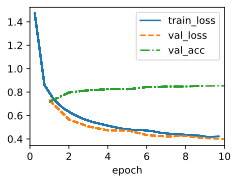

In [5]:
hparams = {'num_outputs':10, 'num_hiddens_1':256, 'num_hiddens_2':256,
           'dropout_1':0.5, 'dropout_2':0.5, 'lr':0.1}
model = DropoutMLPScratch(**hparams)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

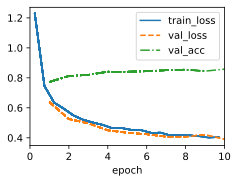

In [7]:
# Concise Implementation
class DropoutMLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2,
                 dropout_1, dropout_2, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.Flatten(), nn.LazyLinear(num_hiddens_1), nn.ReLU(),
            nn.Dropout(dropout_1), nn.LazyLinear(num_hiddens_2), 
#            nn.Dropout(dropout_1), nn.LazyLinear(num_hiddens_2), nn.ReLU(),
            nn.Dropout(dropout_2), nn.LazyLinear(num_outputs))

''' 
抱歉，我在之前的解释中没有注意到这个问题。在这个版本的`DropoutMLP`类中，ReLU激活函数确实在第二个隐藏层之后被应用了。这是因为这个实现使用了`nn.Sequential`来构建神经网络，它将所有层按顺序堆叠在一起。

然而，这并不意味着在第二个隐藏层之后应用ReLU激活函数是必需的。在这种情况下，ReLU激活函数在输出层之前被应用，这可能对某些任务有帮助。
但是，在某些任务中，例如多类别分类任务，我们可能会在输出层之后应用softmax激活函数。在这种情况下，可以省略最后一个ReLU激活函数。

请注意，两个实现之间的差异主要在于网络结构的组织方式。第一个实现（`DropoutMLPScratch`）在`forward`函数中明确地指定了前向传播过程，而第二个实现（`DropoutMLP`）使用了`nn.Sequential`来构建网络。
在实践中，可以根据任务需求和个人喜好选择合适的实现方式。
'''
model = DropoutMLP(**hparams)
trainer.fit(model, data)
